In [106]:
!pip install -q sklearn

In [133]:
TRAIN_PATH = '/content/drive/My Drive/Estudos /Aceleração Data Science/Aulas/Nona semana/desafio/train.csv'
TEST_PATH = '/content/drive/My Drive/Estudos /Aceleração Data Science/Aulas/Nona semana/desafio/test.csv'

In [134]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns 

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [135]:
train_data = pd.read_csv(TRAIN_PATH)
test_data_or = pd.read_csv(TEST_PATH)

train_data.drop(labels='Unnamed: 0', axis=1, inplace=True) # índice que veio como coluna no dataset

In [136]:
new_train_columns = test_data_or.columns.to_list()
new_train_columns.append('IN_TREINEIRO') # adicionando a coluna de treineiro dos dados de treino
train_data = train_data[new_train_columns].copy()
print('Número de colunas: ', train_data.shape[1])
train_data.head()

Número de colunas:  44


,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,IN_TREINEIRO
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,1,436.3,495.4,581.2,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,C,A,A,C,H,A,0
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,1.0,2.0,0,0,0,0,0,0,0,0,1,1,1,1,474.5,544.1,599.0,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,B,A,A,A,NaN,A,0
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,C,A,A,A,NaN,A,0
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,E,C,B,C,F,D,0
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,D,C,A,A,B,F,A,0


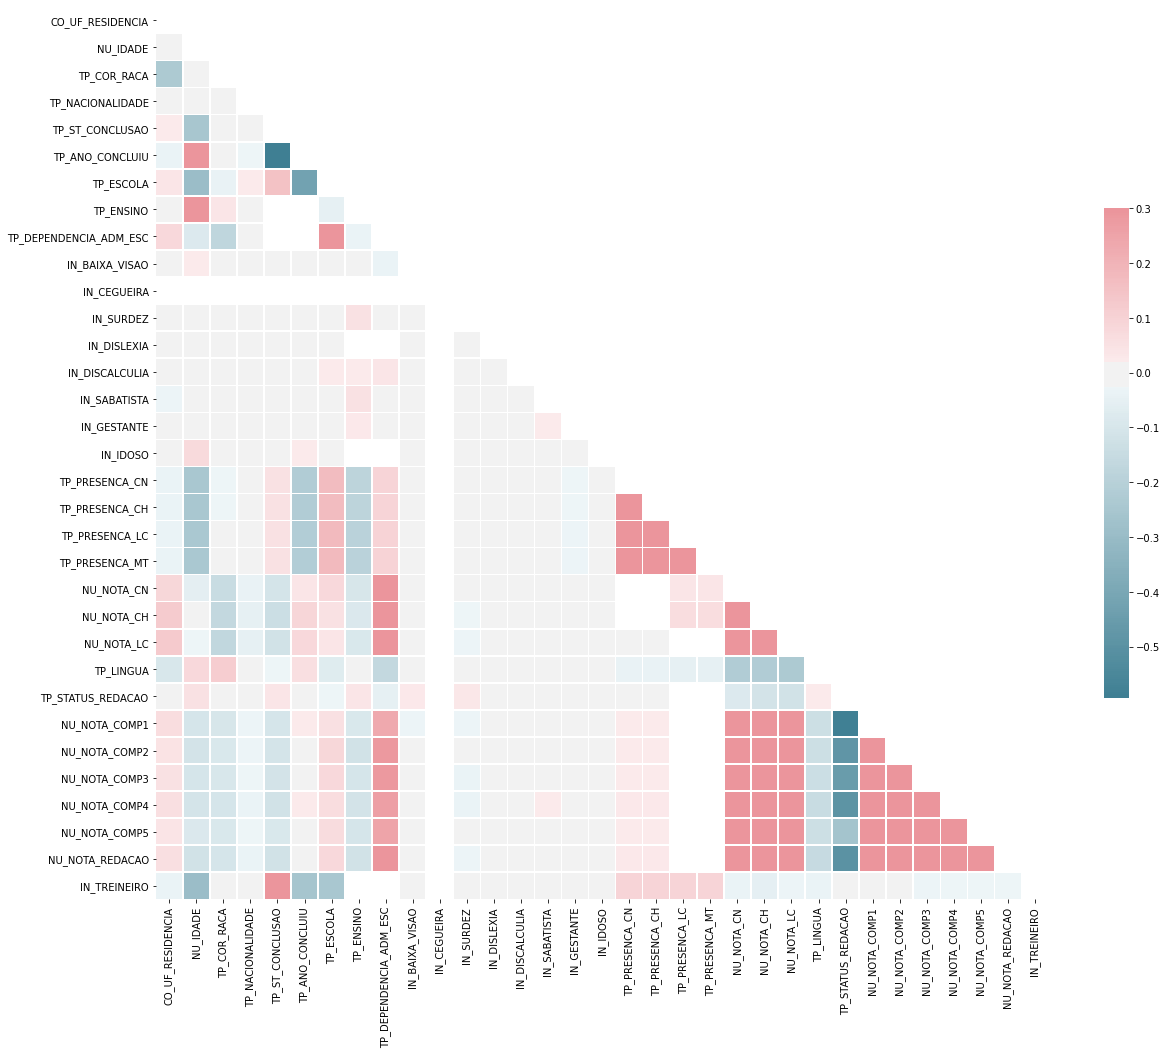

In [137]:
# código de: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = train_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [138]:
# Generate a custom diverging colormap
train_data[train_data.columns[1:]].corr()['IN_TREINEIRO'].abs().sort_values(ascending=False)[:11]

IN_TREINEIRO       1.000000
TP_ST_CONCLUSAO    0.533983
NU_IDADE           0.295091
TP_ANO_CONCLUIU    0.257710
TP_ESCOLA          0.244562
TP_PRESENCA_CH     0.094692
TP_PRESENCA_CN     0.094692
TP_PRESENCA_LC     0.092454
TP_PRESENCA_MT     0.092454
NU_NOTA_CH         0.053460
NU_NOTA_CN         0.037874
Name: IN_TREINEIRO, dtype: float64

In [139]:
desired_columns = ['IN_TREINEIRO', 'TP_ST_CONCLUSAO', 'NU_IDADE', 'TP_ANO_CONCLUIU', 
                   'TP_ESCOLA', 'TP_PRESENCA_CH', 'TP_PRESENCA_CN', 'TP_PRESENCA_LC', 
                   'TP_PRESENCA_MT', 'NU_NOTA_CH', 'NU_NOTA_CN']

# realiza a segunda filtragem, pegando apenas as 10 colunas com maior correlação com a coluna de treineiro
train_data = train_data[desired_columns].copy()

train_data.head()

,IN_TREINEIRO,TP_ST_CONCLUSAO,NU_IDADE,TP_ANO_CONCLUIU,TP_ESCOLA,TP_PRESENCA_CH,TP_PRESENCA_CN,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CH,NU_NOTA_CN
0,0,1,24,4,1,1,1,1,1,495.4,436.3
1,0,2,17,0,2,1,1,1,1,544.1,474.5
2,0,3,21,0,1,0,0,0,0,NaN,NaN
3,0,1,25,9,1,0,0,0,0,NaN,NaN
4,0,1,28,4,1,0,0,0,0,NaN,NaN


In [140]:
test_data = test_data_or[desired_columns[1:]].copy()

In [141]:
train_data.replace(np.nan, -1, inplace=True)
test_data.replace(np.nan, -1, inplace=True)

In [142]:
train, val = train_test_split(train_data, test_size=0.2)
print(len(train))
print(len(val))

10984
2746


In [143]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32, test=False):
  dataframe = dataframe.copy()
  if not test:
    labels = dataframe.pop('IN_TREINEIRO')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  else: 
    ds = tf.data.Dataset.from_tensor_slices(dataframe)
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [144]:
feature_columns = []

# numeric cols
for header in desired_columns[1:]:
  feature_columns.append(feature_column.numeric_column(header))

In [145]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [146]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=True, batch_size=batch_size)
test_ds = df_to_dataset(test_data, shuffle=False, batch_size=batch_size, test=True)

In [147]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.
332/344 [===========================>..] - ETA: 0s - loss: 1.5476 - accuracy: 0.8243WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'TP_ST_CONCLUSAO': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=int64>, 'NU_IDADE': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'TP_ANO_CONCLUIU': <tf.Tensor 

In [148]:
predictions = model.predict_classes(dict(test_data))

Consider rewriting this model with the Functional API.


In [150]:
result = pd.DataFrame()
result['NU_INSCRICAO'] = test_data_or['NU_INSCRICAO'].copy()
result['IN_TREINEIRO'] = predictions
result

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
...,...,...
4565,361b7fcd8867119550fe2af5aa729ffad89a7cf5,0
4566,d8a0e4c9e29494cc9bba2422bd79333931475ee1,0
4567,3f1c3388244df8d6521e983a809292d9f3bca643,0
4568,1778e9c4cef591beb6b986d191d15ed05de816b0,0


In [151]:
result.to_csv('/content/drive/My Drive/Estudos /Aceleração Data Science/Aulas/Nona semana/desafio/answer.csv', index=False)